# **Drive, acceso al archivo, descomprimir, y carga de dataset**

En este paso, conecgtamos con Google Drive y accedemos al archivo tw_source.csv.zip.Se descomprime el archivo y se extraer el archivo CSV interno. Dado que puede tener problemas de codificación, se prueba varias opciones hasta encontrar la correcta (funcionó con latin1). Posterior, se cargó los datos en un DataFrame df listo para analizar.

In [56]:
# === Instalar librerías necesarias ===
!pip -q install langdetect Unidecode wordcloud spacy nltk

# Modelos de spaCy (ejecuta una sola vez; si no puedes descargarlos, el código caerá a stemming)
!python -m spacy download es_core_news_sm
!python -m spacy download en_core_web_sm

# Descargar stopwords de NLTK (una sola vez)
import nltk
nltk.download('stopwords')


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 36.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 56.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [57]:
from pathlib import Path

# === OPCIÓN A: CSV directo ya en /content (autodetección) ===
DEFAULT_CSV = Path('/content/tw_wource.csv')

# === OPCIÓN B: ZIP en Drive (ajusta la ruta y activa USE_ZIP) ===
USE_ZIP = False  # <-- ponlo en True si vas a leer desde ZIP
ZIP_PATH = Path('/content/drive/MyDrive/tu_carpeta/tw.zip')  # <-- AJUSTA si usarás ZIP
UNZIP_DIR = Path('/content/tw_unzipped')  # carpeta donde se extrae

print({'USE_ZIP': USE_ZIP, 'DEFAULT_CSV_exists': DEFAULT_CSV.exists(), 'ZIP_PATH': str(ZIP_PATH)})


{'USE_ZIP': False, 'DEFAULT_CSV_exists': True, 'ZIP_PATH': '/content/drive/MyDrive/tu_carpeta/tw.zip'}


In [58]:
import zipfile, os, glob

all_files = []

if USE_ZIP:
    UNZIP_DIR.mkdir(parents=True, exist_ok=True)
    with zipfile.ZipFile(ZIP_PATH, 'r') as z:
        z.extractall(UNZIP_DIR)
    # buscar archivos válidos
    all_files = []
    for ext in ('*.csv','*.json','*.jsonl','*.CSV','*.JSON','*.JSONL'):
        all_files.extend(list(UNZIP_DIR.rglob(ext)))
    print(f'Archivos detectados en ZIP: {len(all_files)}')
    for p in all_files[:10]:
        print('-', p)
else:
    if DEFAULT_CSV.exists():
        all_files = [DEFAULT_CSV]
        print('Usando CSV directo:', DEFAULT_CSV)
    else:
        print('No hay ZIP ni CSV por defecto. Revisa Celda 2.')


Usando CSV directo: /content/tw_wource.csv


In [61]:
import pandas as pd
import re
from pathlib import Path

def try_read_csv(path, header, encodings=('utf-8','utf-8-sig','latin1','cp1252')):
    """
    Intenta leer un CSV probando varios encodings y autodetectando separador.
    Usa engine='python' (soporta sep=None).
    ¡Ojo! low_memory no está soportado aquí, así que lo quitamos.
    """
    last_err = None
    for enc in encodings:
        try:
            df = pd.read_csv(
                path,
                header=header,
                sep=None,              # autodetecta separador
                engine='python',       # necesario para sep=None
                on_bad_lines='skip',
                encoding=enc,
                encoding_errors='replace'  # evita que explote por bytes raros
            )
            return df, enc
        except Exception as e:
            last_err = e
    raise last_err

def load_one_file(path):
    path = Path(path)
    suf = path.suffix.lower()
    if suf == '.csv':
        # 1) Intento con cabecera
        try:
            df, enc = try_read_csv(path, header='infer')
            has_header = True
            print(f"[OK] CSV con header usando encoding '{enc}': {path.name}  shape={df.shape}")
            return df, has_header
        except Exception as e1:
            print(f"[Aviso] Falló lectura con header ('infer'): {e1}. Reintentando sin header…")
            # 2) Intento sin cabecera
            df, enc = try_read_csv(path, header=None)
            has_header = False
            print(f"[OK] CSV sin header usando encoding '{enc}': {path.name}  shape={df.shape}")
            return df, has_header

    elif suf == '.json':
        df = pd.read_json(path)
        print(f"[OK] JSON: {path.name}  shape={df.shape}")
        return df, True
    elif suf == '.jsonl':
        df = pd.read_json(path, lines=True)
        print(f"[OK] JSONL: {path.name}  shape={df.shape}")
        return df, True
    else:
        raise ValueError(f'Formato no soportado: {path}')

def detect_text_col_idx(df, sample_rows=2000):
    """Heurística: detecta la columna de texto si no hay headers."""
    n = min(len(df), sample_rows)
    sample = df.iloc[:n].copy()
    best_idx, best_score = None, -1
    for col in sample.columns:
        s = sample[col].astype(str)
        at_count  = s.str.count(r'@[A-Za-z0-9_]{1,30}').fillna(0).mean()
        mean_len  = s.str.len().fillna(0).mean()
        token_mean= s.str.split().apply(lambda x: len(x) if isinstance(x, list) else 0).mean()
        score = (at_count*3.0) + (mean_len*0.02) + (token_mean*0.5)
        if score > best_score:
            best_score, best_idx = score, col
    return best_idx

# --- Cargar todos los archivos detectados en la Celda 3 ---
dfs = []
has_header_flags = []
for f in all_files:
    df_f, has_header = load_one_file(f)
    dfs.append(df_f)
    has_header_flags.append(has_header)

df = pd.concat(dfs, ignore_index=True) if len(dfs) > 1 else dfs[0]
has_header = all(has_header_flags)
print('Shape total:', df.shape, '| Con encabezados:', has_header)

# --- Elegir columna de texto ---
if has_header:
    candidates = [c for c in df.columns if str(c).lower() in ('text','tweet','full_text','content','body','message')]
    if candidates:
        text_col = candidates[0]
    else:
        temp = df.rename(columns={c:i for i,c in enumerate(df.columns)})
        text_idx = detect_text_col_idx(temp)
        inv = {v:k for k,v in {c:i for i,c in enumerate(df.columns)}.items()}
        text_col = inv[text_idx]
else:
    text_col = detect_text_col_idx(df)

print('Columna de texto detectada:', text_col)

# --- Normalizar a "Content" ---
df = df.rename(columns={text_col: 'Content'})
if 'Content' not in df.columns:
    df['Content'] = df[text_col]
df = df[['Content']].copy()
df['Content'] = df['Content'].astype(str)

df.head()


[OK] CSV con header usando encoding 'utf-8': tw_wource.csv  shape=(1599999, 6)
Shape total: (1599999, 6) | Con encabezados: True
Columna de texto detectada: @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D


,Content
0,is upset that he can't update his Facebook by ...
1,@Kenichan I dived many times for the ball. Man...
2,my whole body feels itchy and like its on fire
3,"@nationwideclass no, it's not behaving at all...."
4,@Kwesidei not the whole crew


## **Exploración inicial y extracción de usuarios mencionados**
Se utiliza expresiones regulares para identificar todas las menciones dentro del texto de los tweets. La expresión @([a-zA-Z0-9_]+) captura cualquier nombre de usuario válido tras la arroba. Luego se cuenta cuántas veces aparece cada uno y se seleccionan los 3 usuarios más populares del dataset.

In [62]:
from collections import Counter

MENTION_RE = re.compile(r'@[A-Za-z0-9_]{1,30}')

def find_mentions(text):
    if not isinstance(text, str): return []
    return MENTION_RE.findall(text)

mention_counter = Counter()
for t in df['Content']:
    mention_counter.update([m.lower().lstrip('@') for m in find_mentions(t)])

top_users = [u for u,_ in mention_counter.most_common(3)]
top_users


['mileycyrus', 'tommcfly', 'ddlovato']

## **Creación de corpus para cada uno de los 3 usuarios**
Para cada uno de los tres usuarios más populares, creamos un corpus personalizado que contiene todos los tweets en los que son mencionados. Cada entrada incluye:

Content: el texto completo del tweet.
Metadata: información adicional como el ID del tweet, fecha (Timestamp) y longitud (Length), calculada como el número de caracteres. Este corpus será la base para el análisis de contexto.

In [63]:
from pathlib import Path
import os, re

OUT_DIR = Path('./outputs_p1')
OUT_DIR.mkdir(parents=True, exist_ok=True)

corpus_paths = {}
for u in top_users:
    mask = df['Content'].str.contains(fr'@{re.escape(u)}\b', case=False, regex=True)
    sub = df.loc[mask, ['Content']].copy()
    sub['Length'] = sub['Content'].str.len()
    out_csv = OUT_DIR / f'corpus_{u}.csv'
    sub.to_csv(out_csv, index=False)
    corpus_paths[u] = out_csv
    print(f'Guardado: {out_csv} ({len(sub)} filas)')


Guardado: outputs_p1/corpus_mileycyrus.csv (4562 filas)
Guardado: outputs_p1/corpus_tommcfly.csv (3898 filas)
Guardado: outputs_p1/corpus_ddlovato.csv (3460 filas)


## **Preprocesamiento del texto (stopwords, stemming, lemmatizacion)**
Antes de analizar el contexto, se limpió y preprocesó el texto, eliminando elementos no informativos como urls, menciones y hashtags. Luego se convierte todo a minúsculas, moviendo puntuaciones y stopwords (palabras como the, y, de). Posterior se aplicó stemming y mellatización para normalizar las palabras. Lo cual pertimirá un análisis más preciso.

In [64]:
import re
from langdetect import detect, DetectorFactory
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, PorterStemmer
from unidecode import unidecode
import spacy

DetectorFactory.seed = 42

# Cargar modelos spaCy (si no están instalados, será None y usaremos stemming)
try:
    nlp_es = spacy.load('es_core_news_sm')
except Exception:
    nlp_es = None
try:
    nlp_en = spacy.load('en_core_web_sm')
except Exception:
    nlp_en = None

STOP_ES = set(stopwords.words('spanish'))
STOP_EN = set(stopwords.words('english'))
STOP_GENERIC = {
    'rt','via','amp','https','http','co','..','—','–','…','u','im','ya','ok',
    'de','la','el','los','las','un','una','unos','unas','y','o','a','en','por','para','con','sin',
    'que','se','su','sus','lo','al','del'
}

STEM_ES = SnowballStemmer('spanish')
STEM_EN = PorterStemmer()

TOK_RE = re.compile(r'@[\w_]{1,30}|[\wáéíóúüñ]+', flags=re.IGNORECASE)

def tokenize_preservando_users(texto:str):
    if not isinstance(texto, str): return []
    t = re.sub(r'https?://\S+|www\.\S+|\S+@\S+', ' ', texto)  # quitar URLs/emails
    return TOK_RE.findall(t)

def extraer_contexto(texto:str, username:str, ventana:int=5):
    """
    Retorna tokens ±ventana alrededor de @username, EXCLUYENDO cualquier token que empiece con '@'.
    """
    tokens = tokenize_preservando_users(texto)
    uname = username.lower().lstrip('@')
    idxs = [i for i,t in enumerate(tokens) if t.lower() == f'@{uname}']
    contexto = []
    for i in idxs:
        left = max(0, i - ventana)
        right = min(len(tokens), i + ventana + 1)
        win = tokens[left:right]
        win_clean = [w for w in win if not w.startswith('@') and len(w) > 1]
        contexto.extend(win_clean)
    return contexto

def limpiar_y_normalizar(tokens):
    """
    Remueve stopwords (ES/EN + genéricas) y aplica lematización (spaCy) o stemming (fallback).
    """
    if not tokens: return []
    snippet = " ".join(tokens[:40])
    try:
        lang = 'es' if detect(unidecode(snippet)).startswith('es') else 'en'
    except Exception:
        lang = 'es'
    stops = STOP_GENERIC | (STOP_ES if lang=='es' else STOP_EN)
    toks = [t for t in tokens if t.lower() not in stops]

    if lang == 'es' and nlp_es is not None:
        doc = nlp_es(" ".join(toks))
        base = [w.lemma_.lower() for w in doc if w.lemma_ and len(w.lemma_)>1]
    elif lang == 'en' and nlp_en is not None:
        doc = nlp_en(" ".join(toks))
        base = [w.lemma_.lower() for w in doc if w.lemma_ and len(w.lemma_)>1]
    else:
        base = [ (STEM_ES.stem(w.lower()) if lang=='es' else STEM_EN.stem(w.lower())) for w in toks ]

    base = [b for b in base if any(ch.isalpha() for ch in b)]
    return base


## **Generación de WordCloud con las 10 palabras más frecuentes por usuario**
Acá se visualiza el contexto de cada usuairo mediante una nube de palabras, muestra 10 palabras más frecuentes que aparecen cerca de su mención en los tweets. El tamaño de cada palabra refleja su relevancia. Además esta gráfica ayuda a identificar temas recurrentes.

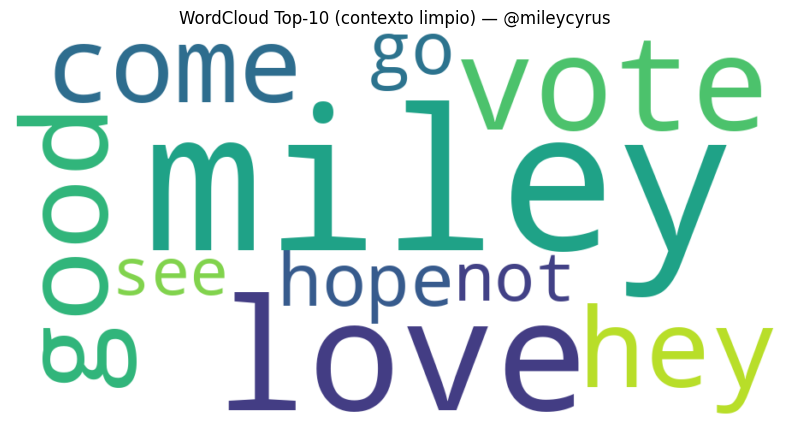

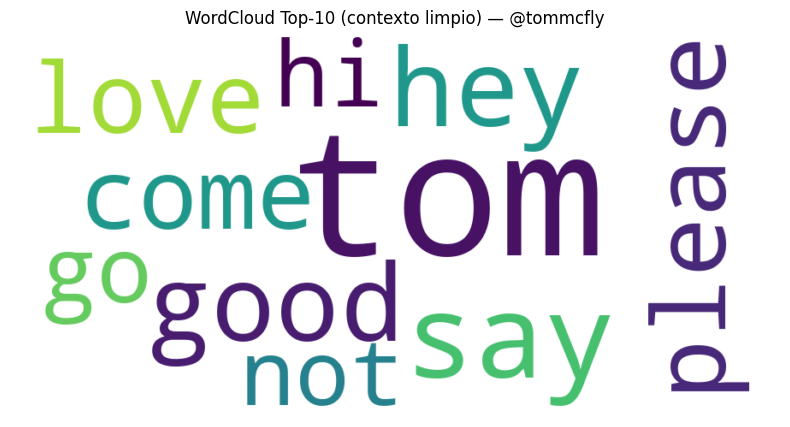

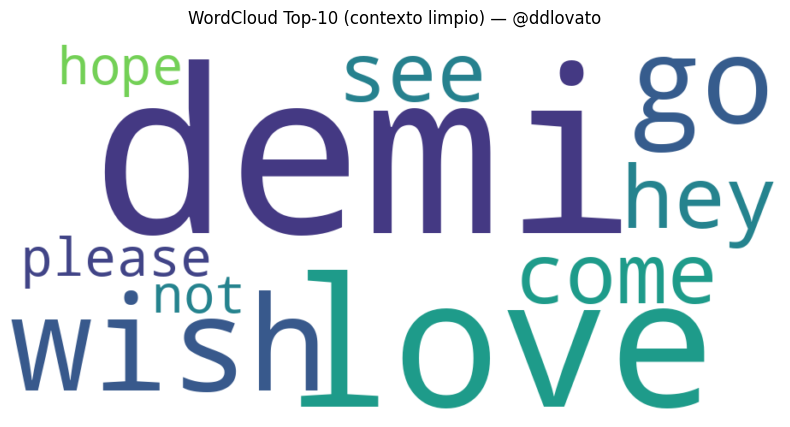

,username,n_tweets_corpus,unique_terms_context,top10_csv,wordcloud_png
0,mileycyrus,4562,2184,outputs_p1/top10_context_mileycyrus.csv,outputs_p1/wordcloud_context_mileycyrus.png
1,tommcfly,3898,1856,outputs_p1/top10_context_tommcfly.csv,outputs_p1/wordcloud_context_tommcfly.png
2,ddlovato,3460,1869,outputs_p1/top10_context_ddlovato.csv,outputs_p1/wordcloud_context_ddlovato.png


In [65]:
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd

VENTANA = 5  # ±5 tokens

resumen = []

for u, path_csv in corpus_paths.items():
    df_u = pd.read_csv(path_csv)
    ctx_tokens = []
    for txt in df_u['Content'].astype(str):
        ctx_tokens.extend(extraer_contexto(txt, u, ventana=VENTANA))

    base_terms = limpiar_y_normalizar(ctx_tokens)
    freqs = Counter(base_terms)
    top10 = freqs.most_common(10)

    wc = WordCloud(width=900, height=450, background_color='white')
    wc.generate_from_frequencies(dict(top10))

    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'WordCloud Top-10 (contexto limpio) — @{u}')
    plt.show()

    out_img = OUT_DIR / f'wordcloud_context_{u}.png'
    wc.to_file(str(out_img))

    out_top = OUT_DIR / f'top10_context_{u}.csv'
    pd.DataFrame(top10, columns=['token','freq']).to_csv(out_top, index=False)

    resumen.append({
        'username': u,
        'n_tweets_corpus': int(len(df_u)),
        'unique_terms_context': int(len(freqs)),
        'top10_csv': str(out_top),
        'wordcloud_png': str(out_img)
    })

summary_df = pd.DataFrame(resumen)
summary_df.to_csv(OUT_DIR / 'resumen_contexto_usuarios.csv', index=False)
summary_df


### **¿Razón por la que citan a ese usuario?**
Acá se aplica top 30 raw (contexto sin limpiar) top 30 clean (stopwords + lemma/stem)


In [72]:
# === VER Y JUSTIFICAR LOS 3 USUARIOS (RAW / CLEAN) ===
import pandas as pd
from collections import Counter
from pathlib import Path
import unicodedata, re
from IPython.display import display, Markdown

# ----- helpers que dependen del pipeline -----
def asegurar_corpus_paths(corpus_paths, carpeta="./outputs_p1"):
    """Si no existe el dict corpus_paths, lo arma desde los archivos corpus_*.csv."""
    if corpus_paths and isinstance(corpus_paths, dict) and len(corpus_paths) > 0:
        return corpus_paths
    cp = {}
    for p in Path(carpeta).glob("corpus_*.csv"):
        cp[p.stem.replace("corpus_","")] = p
    return cp

def top_tokens_usuario(usuario, top_n=30, ventana=5, corpus_paths=None):
    """Devuelve (raw_df, clean_df) con Top-N tokens de CONTEXTO ±ventana para @usuario."""
    cp = asegurar_corpus_paths(corpus_paths)
    assert usuario in cp, f"No encuentro corpus para @{usuario}. Disponible: {list(cp.keys())}"
    df_u = pd.read_csv(cp[usuario])

    # tokens del CONTEXTO (sin @menciones)
    raw_tokens = []
    for txt in df_u['Content'].astype(str):
        raw_tokens.extend(extraer_contexto(txt, usuario, ventana=ventana))

    clean_tokens = limpiar_y_normalizar(raw_tokens)
    raw_df   = pd.DataFrame(Counter(raw_tokens).most_common(top_n),  columns=['token_raw','freq'])
    clean_df = pd.DataFrame(Counter(clean_tokens).most_common(top_n), columns=['token_clean','freq'])
    return raw_df, clean_df

# Vocabulario heurístico de temas
TEMAS = {
    'eventos/fandom': {'concierto','tour','entrada','fans','show','gira','escenario','festival','boleto','meet','movie','film'},
    'soporte/producto': {'soporte','bug','error','fallo','actualizacion','version','release','ticket','arreglar','crash','parche','reporte'},
    'política/opinión pública': {'votar','vote','eleccion','gobierno','propuesta','debate','campana','presidente','ministro','congreso','partido','ley'},
    'promociones/marketing': {'promocion','descuento','oferta','cupon','rebaja','gratis','envio','liquidacion','promo','sale','deal'},
    'controversia': {'polemica','critica','acusacion','cancelar','rumor','falso','verdad','boicot','denuncia','drama'},
    'deportes': {'partido','gol','equipo','liga','fichaje','jornada','campeon','mundial','marcador','entrenador'},
    'emociones/apoyo': {'love','like','amazing','hope','luck','please','win','aww','wish','thanks','congrats','awesome','best'},
}

def norm(t):
    t = t.lower()
    return ''.join(c for c in unicodedata.normalize('NFKD', t) if not unicodedata.combining(c))

def inferir_tema(top_tokens):
    """top_tokens: list[(token, freq)] -> tema principal o 'tópicos generales del contexto'."""
    puntajes = {k:0 for k in TEMAS}
    for tok, f in top_tokens:
        n = norm(tok)
        for tema, vocab in TEMAS.items():
            if n in vocab:
                puntajes[tema] += f
    ranked = sorted(puntajes.items(), key=lambda x: x[1], reverse=True)
    ranked = [(t,p) for t,p in ranked if p>0]
    return ranked[0][0] if ranked else "tópicos generales del contexto"

def justificar_usuario(usuario, top_n=15, ventana=5, corpus_paths=None):
    raw, clean = top_tokens_usuario(usuario, top_n=top_n, ventana=ventana, corpus_paths=corpus_paths)
    top_clean_pairs = list(clean.itertuples(index=False, name=None))[:10]  # (token, freq)
    tema = inferir_tema(top_clean_pairs)
    palabras = [t for t,_ in top_clean_pairs[:6]]
    if tema == "tópicos generales del contexto":
        razon = "por tópicos recurrentes observados en el contexto de sus menciones"
    else:
        razon = f"principalmente por temas de {tema}"
    parrafo = (
        f"**@{usuario}**: Se le cita {razon}. Entre las palabras más frecuentes del contexto "
        f"se encuentran: {', '.join(palabras)}."
    )
    return parrafo, raw, clean

# ----- determinar los 3 usuarios -----
cp_auto = asegurar_corpus_paths(globals().get("corpus_paths"))
if 'top_users' in globals() and len(top_users) >= 3:
    users = top_users[:3]
else:
    # inferir desde nombres de archivo corpus_*.csv
    users = sorted(cp_auto.keys())[:3]
assert users, "No hay usuarios detectados. Asegúrate de tener corpus_*.csv o top_users definido."

# ----- parámetros -----
TOP_N   = 30
VENTANA = 5

# ----- mostrar resultados para los 3 usuarios -----
for u in users:
    display(Markdown(f"## @{u}"))
    parrafo, raw_df, clean_df = justificar_usuario(u, top_n=TOP_N, ventana=VENTANA, corpus_paths=cp_auto)
    display(Markdown(parrafo))
    display(Markdown("**Top30 RAW (contexto sin limpiar):**"))
    display(raw_df.head(TOP_N))
    display(Markdown("**Top30 CLEAN (stopwords + lemma/stem):**"))
    display(clean_df.head(TOP_N))
    display(Markdown("---"))


## @mileycyrus

**@mileycyrus**: Se le cita principalmente por temas de emociones/apoyo. Entre las palabras más frecuentes del contexto se encuentran: miley, love, vote, good, hey, come.

**Top30 RAW (contexto sin limpiar):**

,token_raw,freq
0,you,1100
1,to,470
2,the,419
3,for,312
4,miley,306
5,love,270
6,is,265
7,and,245
8,Miley,236
9,your,234


**Top30 CLEAN (stopwords + lemma/stem):**

,token_clean,freq
0,miley,587
1,love,344
2,vote,235
3,good,196
4,hey,174
5,come,162
6,hope,149
7,go,145
8,not,126
9,see,115


---

## @tommcfly

**@tommcfly**: Se le cita principalmente por temas de emociones/apoyo. Entre las palabras más frecuentes del contexto se encuentran: tom, say, hey, good, please, love.

**Top30 RAW (contexto sin limpiar):**

,token_raw,freq
0,you,1044
1,to,409
2,the,356
3,Tom,264
4,tom,260
5,it,194
6,are,177
7,that,173
8,is,172
9,me,170


**Top30 CLEAN (stopwords + lemma/stem):**

,token_clean,freq
0,tom,555
1,say,182
2,hey,154
3,good,152
4,please,136
5,love,129
6,come,128
7,go,115
8,not,111
9,hi,110


---

## @ddlovato

**@ddlovato**: Se le cita principalmente por temas de emociones/apoyo. Entre las palabras más frecuentes del contexto se encuentran: demi, love, wish, go, hey, come.

**Top30 RAW (contexto sin limpiar):**

,token_raw,freq
0,you,717
1,to,443
2,and,246
3,the,226
4,demi,222
5,is,221
6,love,199
7,that,188
8,your,186
9,so,181


**Top30 CLEAN (stopwords + lemma/stem):**

,token_clean,freq
0,demi,419
1,love,240
2,wish,162
3,go,137
4,hey,120
5,come,115
6,see,110
7,please,104
8,not,100
9,hope,99


---

## **1) @mileycyrus**

Evidencia (tokens contexto): miley, love, vote, good, hey, come, hope, please, luck, like, really, win, amazing, follow…

Lectura: Predominan términos afectivos (love, amazing, hope, luck) y llamados a la acción de apoyo/votación (vote, win, follow), además de saludos e invitaciones (hey, come).

Conclusión: La citan principalmente por fandom/expresiones de apoyo y para movilizar votos o acciones de respaldo (concursos/campañas).

## **2) @tommcfly**

Evidencia (tokens contexto): tom, say, hey, good, please, love, come, go, hi, like, haha, get, see, reply, miss, think, guy, happy, hope, want, birthday…

Lectura: Abundan saludos e interacción directa (hey, hi, say, reply), peticiones (please, reply), afecto (love, miss, happy), y felicitaciones (birthday), con tono conversacional (haha, oh, really).

Conclusión: La citación se explica por interacción cercana con fans: saludos, pedidos de respuesta, felicitaciones y muestras de afecto/apoyo.

## **3) @ddlovato**

Evidencia (tokens contexto): demi, love, wish, go, hey, come, see, please, hope, good, awesome, wait, want, haha, really, like, hi, know, well, omg, vote, make, would, fun, ur…

Lectura: Mezcla de apoyo emocional (love, hope, awesome, omg), deseos/ánimo (wish, wait, want), saludos y llamados a acción (please, come, see, vote).

Conclusión: Se le cita por fandom y ánimo/soporte, con invitaciones/llamados a acción (aparecen vote, come, see) y un tono entusiasta.